In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "Twitter15-RNR"
unique_name = "RoBERTa_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Twitter15-RNR_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(1490, 768)

In [3]:
data = pd.read_csv("../../data/processed/twitter15_dataset_with_tvt.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,tvt,cv_fold,tt,tvt2,tvt2_1,tvt2_2,tvt2_3
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,training,1,training,training,validation,training,training
1,714598641827246081,an open letter to trump voters from his top st...,unverified,training,1,test,training,testting,training,training
2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor,training,2,training,validation,validation,validation,testting
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor,training,1,training,testting,testting,training,training
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,training,3,training,validation,training,validation,training


In [4]:
labels_str = ['rumour', 'non-rumour']
labels_str

['rumour', 'non-rumour']

In [5]:
labels = []
for i, d in data.iterrows():
#     lab = labels_str.index(d['label'])
    if d['label'] in ['true', 'false', 'unverified']:
        lab = 0
    else:
        lab = 1
    labels.append(lab)
labels[:10]

[0, 0, 1, 1, 0, 1, 0, 0, 0, 0]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(1024, 768)
(338, 768)
(128, 768)
(1024,)
(338,)
(128,)


In [8]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(1362, 768)


In [9]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(1362,)


In [10]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNModel(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int = 1
    ):
        super(NNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_output)
        )

    def forward(self, input):
        return self.main(input)
    

class NNClassifier:
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = NNModel(n_input, n_output)

        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"loading model from {filepath}...")
#         print(checkpoint[key])
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets=inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
            
            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss/len(trainloader))
            

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()
            
                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss/len(testloader))
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
            # if saves and test_loss < best_loss:
            #     print(f"Saving after new best loss : {test_loss}")
            #     best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break
            
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_2LayerNet_L2Reg_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_2LayerNet_L2Reg_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [11]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

Multiclass Classification using 2-Layer Linear Network Cross Validation
--- FOLD 1 ----
Using cuda
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 96.32690541781452, Validation Accuracy : 100.0, Train Loss : 0.38236294128000736, Validation Loss : 0.02088344842195511
-- Epoch 100, Train_Accuracy : 97.24517906336088, Validation Accuracy : 100.0, Train Loss : 0.24865196272730827, Validation Loss : 0.01363364327698946
-- Epoch 150, Train_Accuracy : 98.34710743801652, Validation Accuracy : 99.63369963369964, Train Loss : 0.16869371384382248, Validation Loss : 0.012420952320098877
-- Epoch 200, Train_Accuracy : 98.62258953168045, Validation Accuracy : 99.63369963369964, Train Loss : 0.11509571224451065, Validation Loss : 0.01813649758696556
-- Epoch 250, Train_Accuracy : 99.54086317722681, Validation Accuracy : 99.63369963369964, Train Loss : 0.07522353529930115, Validation Loss : 0.0165029875934124
-- Epoch 300, Train_Accuracy : 99.63269054178146, Validation Accuracy : 

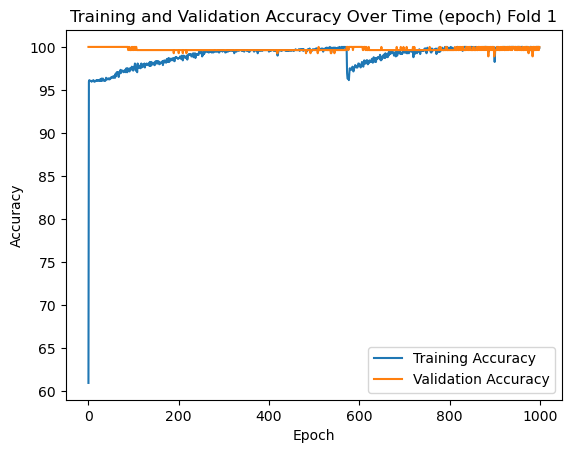

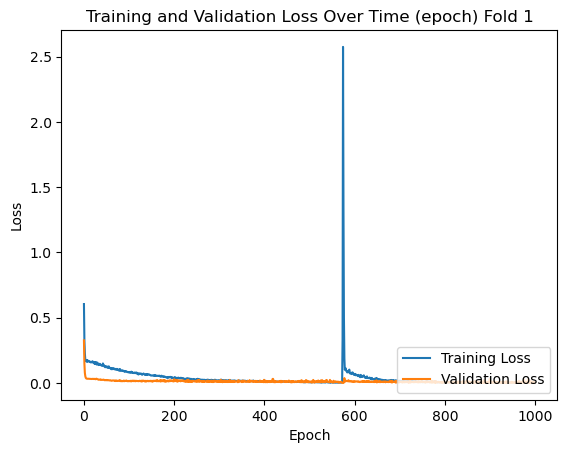

Exec Time : 22.04 seconds
loading model from ../../data/models/cross-validation/Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1.pth...

Train Set
Predictions : torch.Size([1089])
Binary Class Evaluation

True Positive : 245
False Positive : 12
False Negative : 29
True Negative : 803

Class non-rumour Evaluation
- Precision : 95.331 %
- Recall : 89.416 %
- F1 : 0.92279

Class rumour Evaluation
- Precision : 96.514 %
- Recall : 98.528 %
- F1 : 0.97511

Combined Evaluation
- Accuracy : 96.235 %
- Precision : 95.923 %
- Recall : 93.972 %
- F1 : 0.94937
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Train, 96.235, 95.923, 93.972, 0.94937, 95.331, 89.416, 0.92279, 96.514, 98.528, 0.97511, 
Confusion Matrix Scikit-learn: 
[[803  12]
 [ 29 245]]


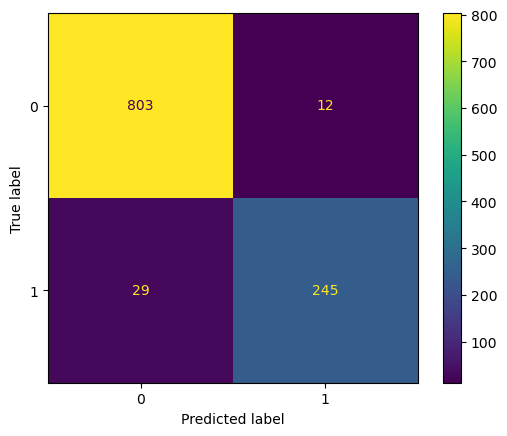


Validation Set
Predictions : torch.Size([273])
Binary Class Evaluation

True Positive : 69
False Positive : 0
False Negative : 0
True Negative : 204

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[204   0]
 [  0  69]]


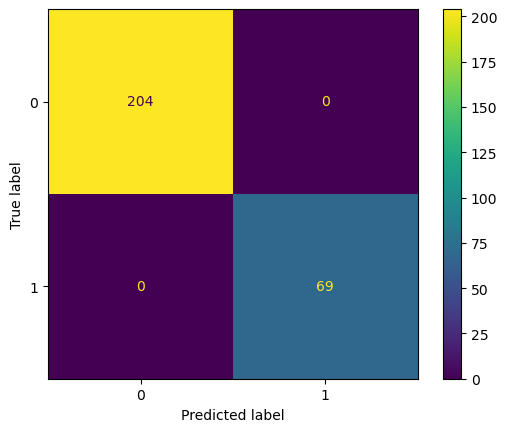


Test Set
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 22
False Positive : 5
False Negative : 9
True Negative : 92

Class non-rumour Evaluation
- Precision : 81.481 %
- Recall : 70.968 %
- F1 : 0.75862

Class rumour Evaluation
- Precision : 91.089 %
- Recall : 94.845 %
- F1 : 0.92929

Combined Evaluation
- Accuracy : 89.062 %
- Precision : 86.285 %
- Recall : 82.907 %
- F1 : 0.84562
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Test, 89.062, 86.285, 82.907, 0.84562, 81.481, 70.968, 0.75862, 91.089, 94.845, 0.92929, 
128
128
Confusion Matrix Scikit-learn: 
[[92  5]
 [ 9 22]]


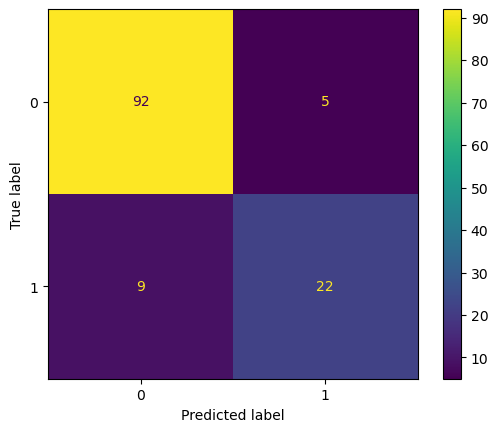

--- FOLD 2 ----
Using cuda
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 96.41873278236915, Validation Accuracy : 100.0, Train Loss : 0.3584724832326174, Validation Loss : 0.023809660226106644
-- Epoch 100, Train_Accuracy : 97.61248852157944, Validation Accuracy : 99.63369963369964, Train Loss : 0.2609002813696861, Validation Loss : 0.017299266532063484
-- Epoch 150, Train_Accuracy : 97.97979797979798, Validation Accuracy : 99.26739926739927, Train Loss : 0.1876043640077114, Validation Loss : 0.021032150834798813
-- Epoch 200, Train_Accuracy : 98.89807162534436, Validation Accuracy : 99.26739926739927, Train Loss : 0.10463414527475834, Validation Loss : 0.023426882922649384
-- Epoch 250, Train_Accuracy : 99.44903581267218, Validation Accuracy : 99.63369963369964, Train Loss : 0.07392906257882714, Validation Loss : 0.016474241390824318
-- Epoch 300, Train_Accuracy : 99.63269054178146, Validation Accuracy : 99.63369963369964, Train Loss : 0.049317842815071344, Vali

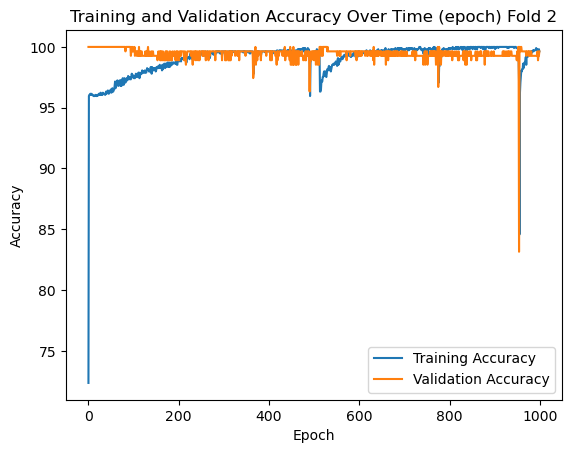

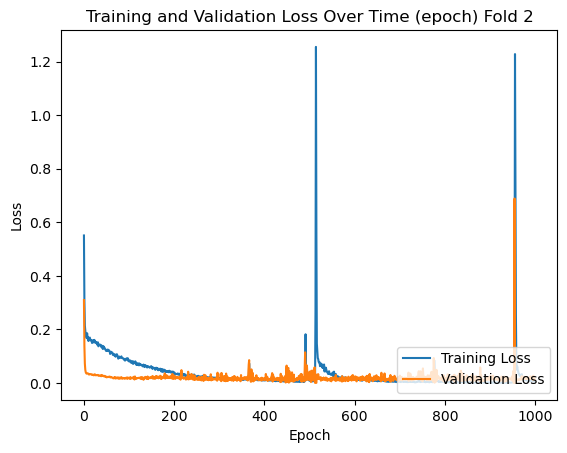

Exec Time : 19.71 seconds
loading model from ../../data/models/cross-validation/Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2.pth...

Train Set
Predictions : torch.Size([1089])
Binary Class Evaluation

True Positive : 242
False Positive : 12
False Negative : 32
True Negative : 803

Class non-rumour Evaluation
- Precision : 95.276 %
- Recall : 88.321 %
- F1 : 0.91667

Class rumour Evaluation
- Precision : 96.168 %
- Recall : 98.528 %
- F1 : 0.97333

Combined Evaluation
- Accuracy : 95.96 %
- Precision : 95.722 %
- Recall : 93.424 %
- F1 : 0.94559
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Train, 95.96, 95.722, 93.424, 0.94559, 95.276, 88.321, 0.91667, 96.168, 98.528, 0.97333, 
Confusion Matrix Scikit-learn: 
[[803  12]
 [ 32 242]]


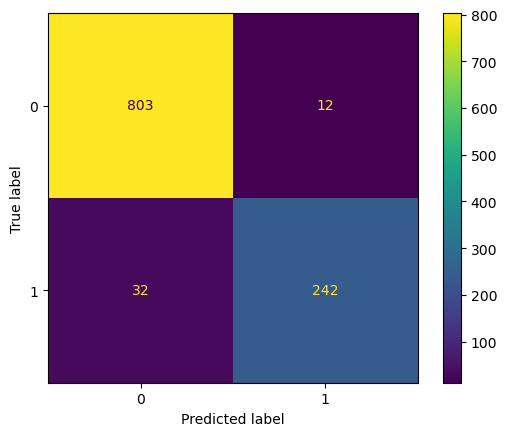


Validation Set
Predictions : torch.Size([273])
Binary Class Evaluation

True Positive : 69
False Positive : 0
False Negative : 0
True Negative : 204

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[204   0]
 [  0  69]]


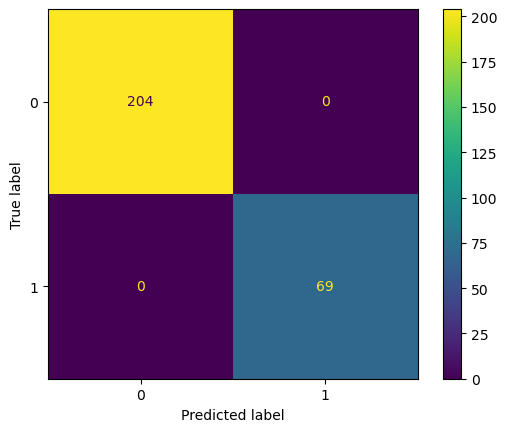


Test Set
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 22
False Positive : 5
False Negative : 9
True Negative : 92

Class non-rumour Evaluation
- Precision : 81.481 %
- Recall : 70.968 %
- F1 : 0.75862

Class rumour Evaluation
- Precision : 91.089 %
- Recall : 94.845 %
- F1 : 0.92929

Combined Evaluation
- Accuracy : 89.062 %
- Precision : 86.285 %
- Recall : 82.907 %
- F1 : 0.84562
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Test, 89.062, 86.285, 82.907, 0.84562, 81.481, 70.968, 0.75862, 91.089, 94.845, 0.92929, 
128
128
Confusion Matrix Scikit-learn: 
[[92  5]
 [ 9 22]]


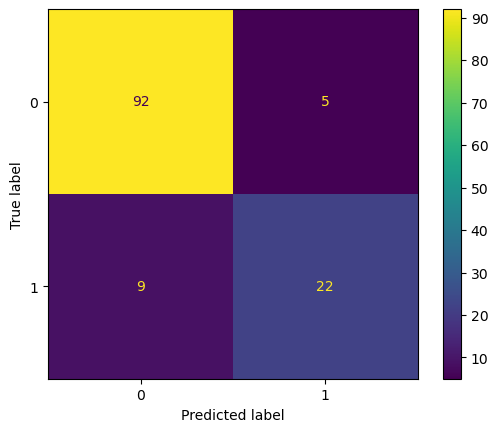

--- FOLD 3 ----
Using cuda
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 96.23853211009174, Validation Accuracy : 100.0, Train Loss : 0.3855474554002285, Validation Loss : 0.023211196064949036
-- Epoch 100, Train_Accuracy : 97.24770642201835, Validation Accuracy : 100.0, Train Loss : 0.2633573841303587, Validation Loss : 0.014626123011112213
-- Epoch 150, Train_Accuracy : 98.25688073394495, Validation Accuracy : 100.0, Train Loss : 0.18001551553606987, Validation Loss : 0.021676398813724518
-- Epoch 200, Train_Accuracy : 98.9908256880734, Validation Accuracy : 99.63235294117646, Train Loss : 0.10061420314013958, Validation Loss : 0.02657526172697544
-- Epoch 250, Train_Accuracy : 98.9908256880734, Validation Accuracy : 100.0, Train Loss : 0.0888272630982101, Validation Loss : 0.010281658731400967
-- Epoch 300, Train_Accuracy : 99.63302752293578, Validation Accuracy : 98.8970588235294, Train Loss : 0.04863945534452796, Validation Loss : 0.02683950588107109
-- Epoc

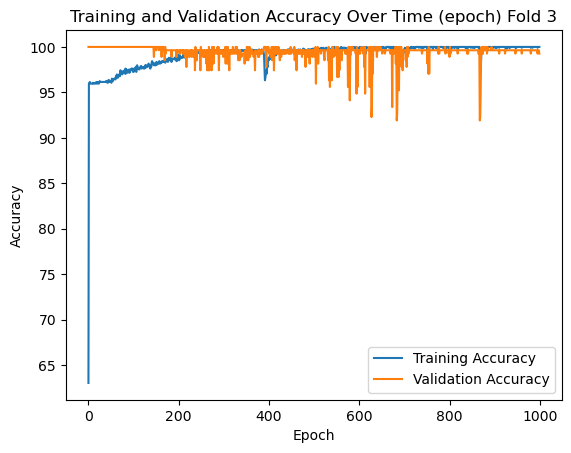

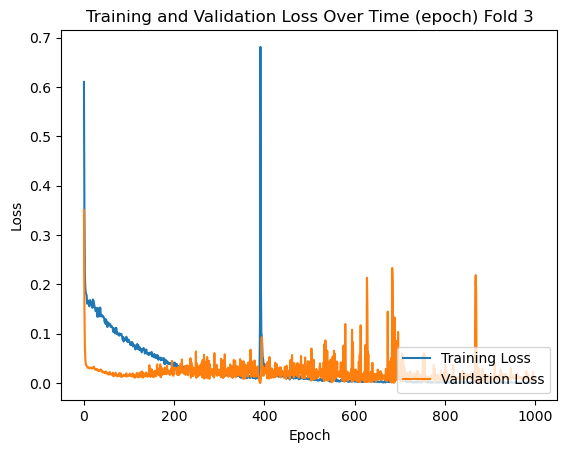

Exec Time : 19.75 seconds
loading model from ../../data/models/cross-validation/Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3.pth...

Train Set
Predictions : torch.Size([1090])
Binary Class Evaluation

True Positive : 246
False Positive : 15
False Negative : 29
True Negative : 800

Class non-rumour Evaluation
- Precision : 94.253 %
- Recall : 89.455 %
- F1 : 0.91791

Class rumour Evaluation
- Precision : 96.502 %
- Recall : 98.16 %
- F1 : 0.97324

Combined Evaluation
- Accuracy : 95.963 %
- Precision : 95.377 %
- Recall : 93.807 %
- F1 : 0.94585
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Train, 95.963, 95.377, 93.807, 0.94585, 94.253, 89.455, 0.91791, 96.502, 98.16, 0.97324, 
Confusion Matrix Scikit-learn: 
[[800  15]
 [ 29 246]]


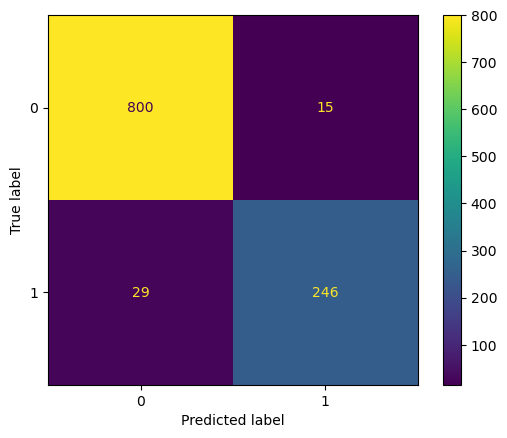


Validation Set
Predictions : torch.Size([272])
Binary Class Evaluation

True Positive : 68
False Positive : 0
False Negative : 0
True Negative : 204

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[204   0]
 [  0  68]]


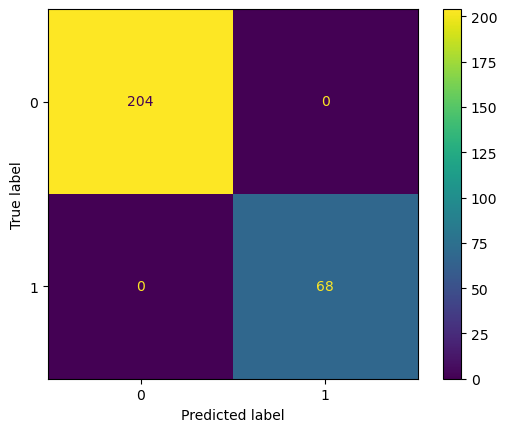


Test Set
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 23
False Positive : 6
False Negative : 8
True Negative : 91

Class non-rumour Evaluation
- Precision : 79.31 %
- Recall : 74.194 %
- F1 : 0.76667

Class rumour Evaluation
- Precision : 91.919 %
- Recall : 93.814 %
- F1 : 0.92857

Combined Evaluation
- Accuracy : 89.062 %
- Precision : 85.615 %
- Recall : 84.004 %
- F1 : 0.84802
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Test, 89.062, 85.615, 84.004, 0.84802, 79.31, 74.194, 0.76667, 91.919, 93.814, 0.92857, 
128
128
Confusion Matrix Scikit-learn: 
[[91  6]
 [ 8 23]]


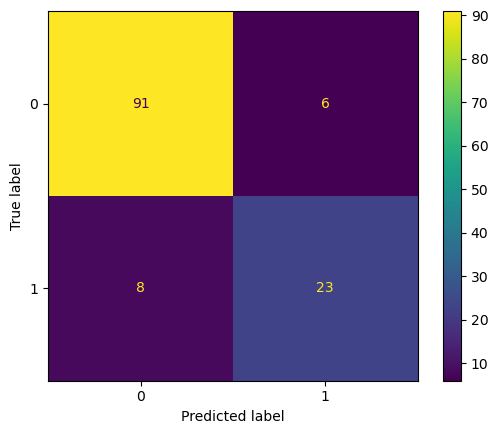

--- FOLD 4 ----
Using cuda
Saving after new best accuracy : 97.79411764705883
-- Epoch 50, Train_Accuracy : 96.88073394495413, Validation Accuracy : 97.42647058823529, Train Loss : 0.34541898407042027, Validation Loss : 0.09072844684123993
-- Epoch 100, Train_Accuracy : 98.25688073394495, Validation Accuracy : 97.05882352941177, Train Loss : 0.2029789350926876, Validation Loss : 0.10582511126995087
-- Epoch 150, Train_Accuracy : 98.71559633027523, Validation Accuracy : 96.69117647058823, Train Loss : 0.13150919694453478, Validation Loss : 0.12589988112449646
-- Epoch 200, Train_Accuracy : 99.35779816513761, Validation Accuracy : 96.69117647058823, Train Loss : 0.0783911319449544, Validation Loss : 0.14422181248664856
-- Epoch 250, Train_Accuracy : 99.35779816513761, Validation Accuracy : 96.32352941176471, Train Loss : 0.07191753759980202, Validation Loss : 0.1587662696838379
-- Epoch 300, Train_Accuracy : 99.54128440366972, Validation Accuracy : 96.69117647058823, Train Loss : 0.05301

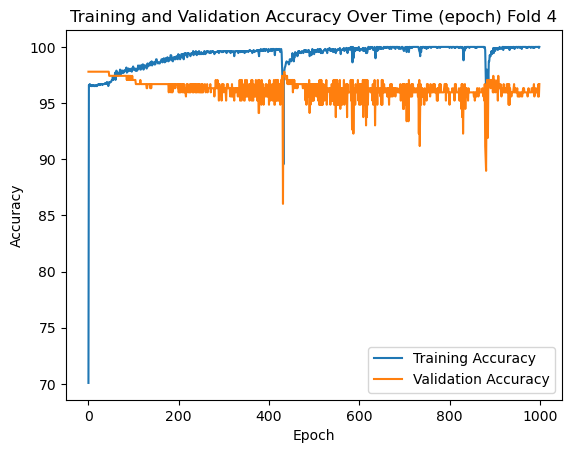

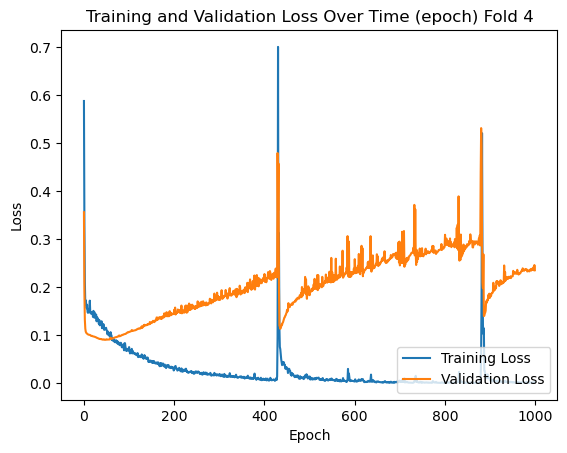

Exec Time : 19.75 seconds
loading model from ../../data/models/cross-validation/Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4.pth...

Train Set
Predictions : torch.Size([1090])
Binary Class Evaluation

True Positive : 251
False Positive : 12
False Negative : 24
True Negative : 803

Class non-rumour Evaluation
- Precision : 95.437 %
- Recall : 91.273 %
- F1 : 0.93309

Class rumour Evaluation
- Precision : 97.098 %
- Recall : 98.528 %
- F1 : 0.97808

Combined Evaluation
- Accuracy : 96.697 %
- Precision : 96.268 %
- Recall : 94.9 %
- F1 : 0.95579
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Train, 96.697, 96.268, 94.9, 0.95579, 95.437, 91.273, 0.93309, 97.098, 98.528, 0.97808, 
Confusion Matrix Scikit-learn: 
[[803  12]
 [ 24 251]]


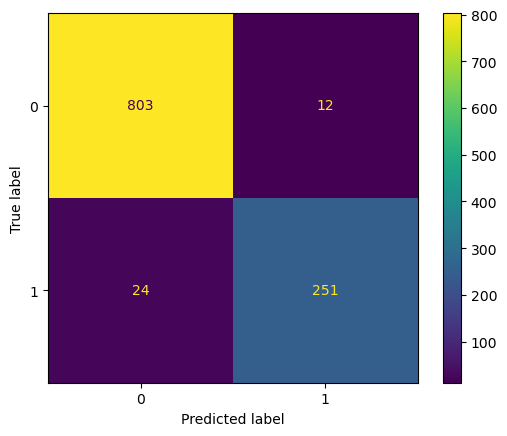


Validation Set
Predictions : torch.Size([272])
Binary Class Evaluation

True Positive : 63
False Positive : 1
False Negative : 5
True Negative : 203

Class non-rumour Evaluation
- Precision : 98.438 %
- Recall : 92.647 %
- F1 : 0.95455

Class rumour Evaluation
- Precision : 97.596 %
- Recall : 99.51 %
- F1 : 0.98544

Combined Evaluation
- Accuracy : 97.794 %
- Precision : 98.017 %
- Recall : 96.078 %
- F1 : 0.97038
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Validation, 97.794, 98.017, 96.078, 0.97038, 98.438, 92.647, 0.95455, 97.596, 99.51, 0.98544, 
Confusion Matrix Scikit-learn: 
[[203   1]
 [  5  63]]


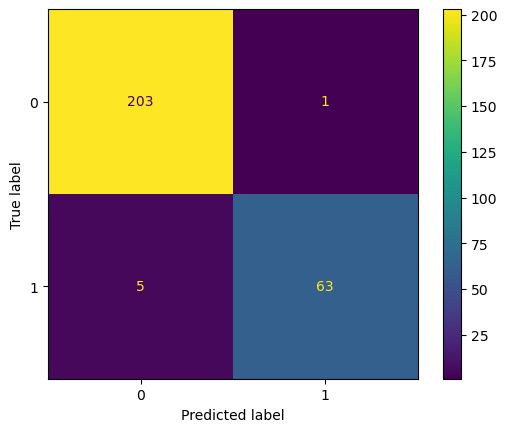


Test Set
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 22
False Positive : 5
False Negative : 9
True Negative : 92

Class non-rumour Evaluation
- Precision : 81.481 %
- Recall : 70.968 %
- F1 : 0.75862

Class rumour Evaluation
- Precision : 91.089 %
- Recall : 94.845 %
- F1 : 0.92929

Combined Evaluation
- Accuracy : 89.062 %
- Precision : 86.285 %
- Recall : 82.907 %
- F1 : 0.84562
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Test, 89.062, 86.285, 82.907, 0.84562, 81.481, 70.968, 0.75862, 91.089, 94.845, 0.92929, 
128
128
Confusion Matrix Scikit-learn: 
[[92  5]
 [ 9 22]]


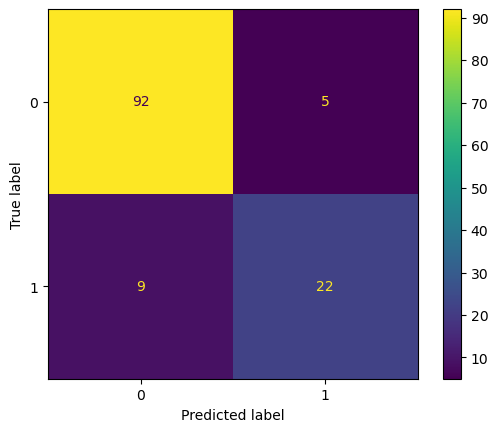

--- FOLD 5 ----
Using cuda
Saving after new best accuracy : 86.3970588235294
-- Epoch 50, Train_Accuracy : 99.44954128440367, Validation Accuracy : 86.3970588235294, Train Loss : 0.1923401216045022, Validation Loss : 0.4967706799507141
-- Epoch 100, Train_Accuracy : 99.81651376146789, Validation Accuracy : 84.92647058823529, Train Loss : 0.05534271651413292, Validation Loss : 0.7965686917304993
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 86.02941176470588, Train Loss : 0.00593174685491249, Validation Loss : 1.0424429178237915
Saving after new best accuracy : 86.76470588235294
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 86.3970588235294, Train Loss : 0.0016235180373769253, Validation Loss : 1.2060736417770386
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 86.3970588235294, Train Loss : 0.0015946161292959005, Validation Loss : 1.2868678569793701
-- Epoch 300, Train_Accuracy : 100.0, Validation Accuracy : 86.3970588235294, Train Loss : 0.000705

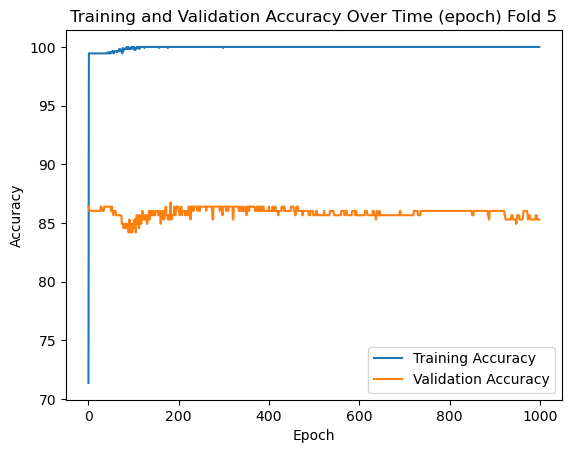

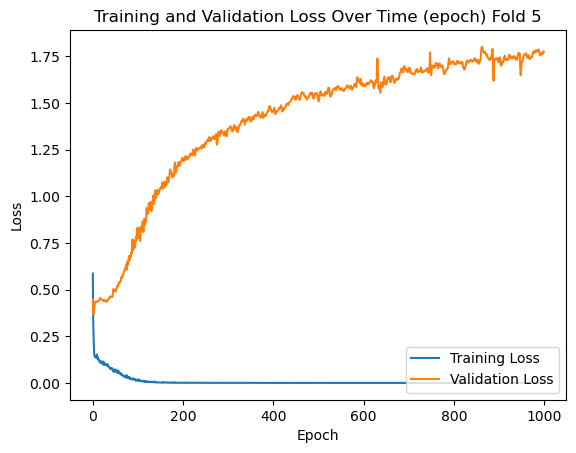

Exec Time : 19.76 seconds
loading model from ../../data/models/cross-validation/Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5.pth...

Train Set
Predictions : torch.Size([1090])
Binary Class Evaluation

True Positive : 274
False Positive : 0
False Negative : 0
True Negative : 816

Class non-rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class rumour Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Train, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[816   0]
 [  0 274]]


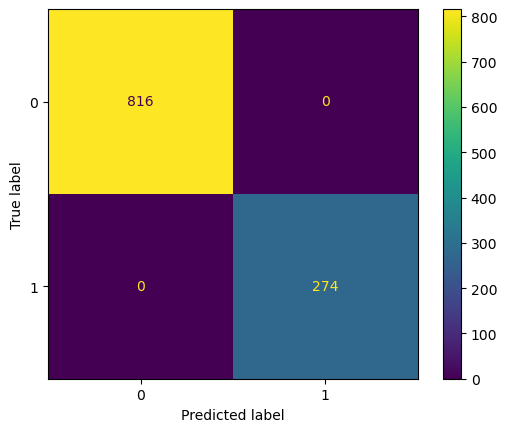


Validation Set
Predictions : torch.Size([272])
Binary Class Evaluation

True Positive : 45
False Positive : 12
False Negative : 24
True Negative : 191

Class non-rumour Evaluation
- Precision : 78.947 %
- Recall : 65.217 %
- F1 : 0.71429

Class rumour Evaluation
- Precision : 88.837 %
- Recall : 94.089 %
- F1 : 0.91388

Combined Evaluation
- Accuracy : 86.765 %
- Precision : 83.892 %
- Recall : 79.653 %
- F1 : 0.81718
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Validation, 86.765, 83.892, 79.653, 0.81718, 78.947, 65.217, 0.71429, 88.837, 94.089, 0.91388, 
Confusion Matrix Scikit-learn: 
[[191  12]
 [ 24  45]]


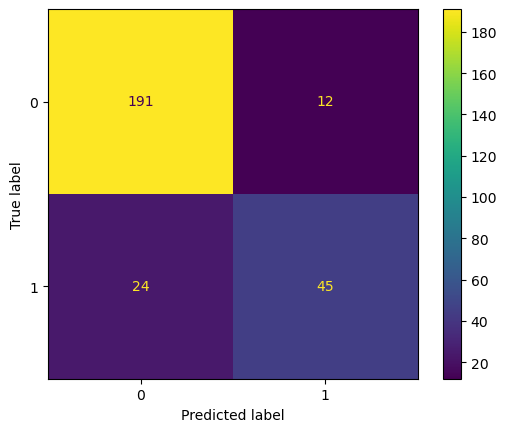


Test Set
Predictions : torch.Size([128])
Binary Class Evaluation

True Positive : 19
False Positive : 7
False Negative : 12
True Negative : 90

Class non-rumour Evaluation
- Precision : 73.077 %
- Recall : 61.29 %
- F1 : 0.66667

Class rumour Evaluation
- Precision : 88.235 %
- Recall : 92.784 %
- F1 : 0.90452

Combined Evaluation
- Accuracy : 85.156 %
- Precision : 80.656 %
- Recall : 77.037 %
- F1 : 0.78805
- Average Confidence : 100.0 %
Model, Combined,,,,non-rumour,,,rumour,,,
Twitter15-RNR_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Test, 85.156, 80.656, 77.037, 0.78805, 73.077, 61.29, 0.66667, 88.235, 92.784, 0.90452, 
128
128
Confusion Matrix Scikit-learn: 
[[90  7]
 [12 19]]


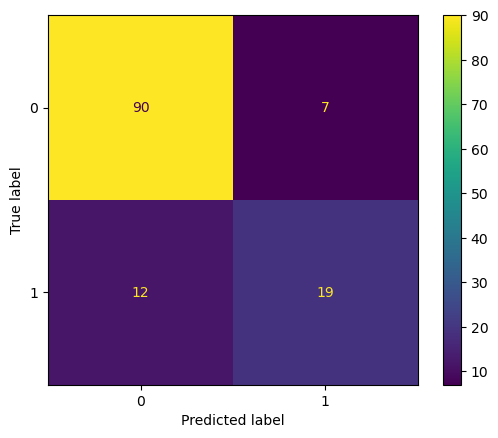

In [12]:
print("Multiclass Classification using 2-Layer Linear Network Cross Validation")

for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
       
    start = time.time()
    model_name = f"{dataset_name}_2LayerNet_L2Reg_{unique_name}_Fold{i+1}"
    model = NNClassifier(train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss)
    model.train_eval(torch.Tensor(train_vectors),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\nTrain Set")
    preds = model.predict(train_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nValidation Set")
    preds = model.predict(val_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nTest Set")
    preds = model.predict(test_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()